## create a connection to the database using the library sqlite3

In [23]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [32]:
df = pd.read_csv("../data/ab-test.csv")
conn = sqlite3.connect("../ex00/data/checking-logs.sqlite.sqlite copy")
df

,uid,diff,time,group
0,user_1,-103.333333,after,test
1,user_1,-6.000000,before,test
2,user_18,-10.000000,after,test
3,user_18,-3.500000,before,test
4,user_19,-82.333333,after,test
5,user_19,-148.000000,before,test
6,user_21,-78.500000,after,test
7,user_21,-112.500000,before,test
8,user_25,-127.500000,after,test
9,user_25,-69.333333,before,test


### Did the same as we did in the previous day (create test table)

In [33]:
query = """SELECT COALESCE(t11.uid,t22.uid) as uid, t11.labname, t11.first_commit_ts, t22.first_view_ts\
        FROM (
            SELECT labname, uid, timestamp AS first_commit_ts
            FROM checker
            WHERE status = 'ready' AND labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1') AND numTrials = 1) t11\
            LEFT JOIN
            (SELECT * FROM ((SELECT uid, datetime as first_view_ts 
            FROM pageviews
            WHERE uid LIKE 'user_%') t1
            INNER JOIN
            (SELECT uid as user_id, min(datetime) as date
            from pageviews
            GROUP BY user_id) t2
            ON t1.uid = t2.user_id AND t1.first_view_ts == t2.date)) t22
        ON t11.uid = t22.uid"""
df = pd.io.sql.read_sql(query, conn, parse_dates=['first_commit_ts', 'first_view_ts'])
df.to_sql('datamart', conn)
df = pd.io.sql.read_sql("select * from datamart", conn, parse_dates=['first_commit_ts', 'first_view_ts'])
test = df.dropna()
test.to_sql('test', conn)

ValueError: Table 'datamart' already exists.

In [69]:
adf = pd.io.sql.read_sql("""
SELECT t11.uid, avg_diff, pageviews, commits FROM
((((SELECT uid, avg((julianday(timestamp) - julianday(datetime(deadlines, 'unixepoch')))) * 24.0 as avg_diff FROM (\
(SELECT * FROM checker) t1
JOIN
(SELECT labs, deadlines from deadlines
        WHERE labs NOT IN ('project1')) t2
        ON t1.labname = t2.labs)
    WHERE uid LIKE 'user_%'
    GROUP BY uid) t11
JOIN
(SELECT uid FROM test) t22
    ON t11.uid = t22.uid) t111
JOIN
    (SELECT uid, COUNT(uid) as pageviews
    FROM pageviews
    GROUP BY uid) t222
    ON t111.uid = t222.uid) last_table
JOIN
    (SELECT uid, COUNT(uid) as commits
    FROM checker
    WHERE uid LIKE 'user_%' AND labname NOT IN ('project1')
    GROUP BY uid) cmts
    ON cmts.uid = t222.uid) last_table
    group by t11.uid
    
""", conn)
adf.head()

,uid,avg_diff,pageviews,commits
0,user_1,-58.634224,28,62
1,user_10,-92.766679,89,20
2,user_14,-194.207550,143,61
3,user_17,-48.743378,47,51
4,user_18,-5.381578,3,5


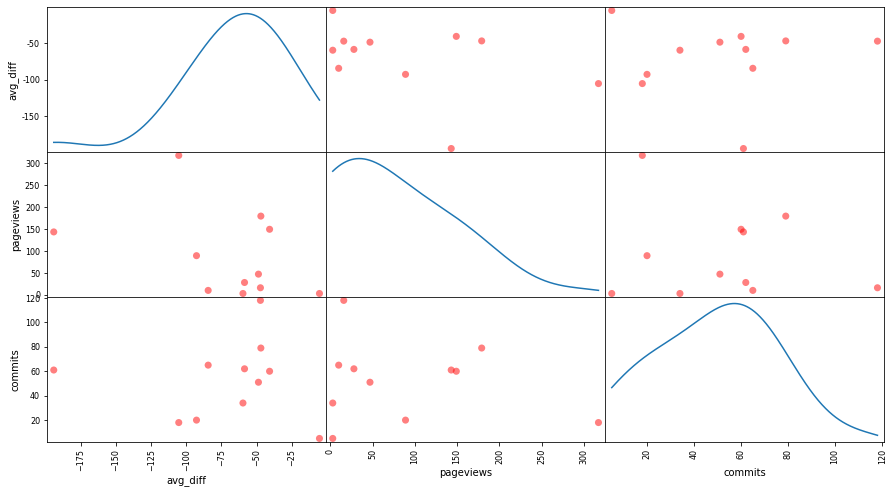

In [83]:
plot = pd.plotting.scatter_matrix(adf, figsize=(15,8), diagonal='kde', s=200, c='red',
                                 linewidth=3)

## “Can we say that if a user has a low number of pageviews then they likely have a low number of commits?” YES
## ◦ “Can we say that if a user has a low number of pageviews then they likely havea small average difference between the first commit and the lab deadline?” NO
## ◦ “Can we say that there are many users with a low number of commits and a few with a high number of commits”?  YES
## ◦ “Can we say that there are many users with a small average difference and a few with a large average difference” YES

In [106]:
conn.close()